<a href="https://colab.research.google.com/github/said-racha/Hybrid-recommender-system-based-on-deep-learning-and-sentiment-analysis/blob/main/Evaluation_SC_NHF_nrml_users_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Traitement pour diviser le Dataset

In [ ]:
import tensorflow as tf
#from keras.layers import Embedding
from tensorflow.keras import Input
from keras.layers.core import Flatten
from keras.layers import *
from keras.models import Model


import pandas as pn
import numpy as np
from sklearn.model_selection import train_test_split


def dataset_split(dataset): #normal testset
    # Spliting into X and y
    X = dataset[['user_id', 'item_id', 'text', 'fans', 'average_stars',
       'friends', 'vote_funny', 'useful', 'vote_cool', 'hot', 'more',
       'profile', 'cute', 'list', 'note', 'plain', 'cool', 'funny', 'writer',
       'photos', 'latitude', 'longitude', 'Breakfast & Brunch',
       'American (Traditional)', 'Burgers', 'Fast Food', 'American (New)',
       'Chinese', 'Pizza', 'Italian', 'Sandwiches', 'Sushi Bars', 'Japanese',
       'Indian', 'Mexican', 'Vietnamese', 'Thai', 'Asian Fusion', 'Take-out',
       'Wi-Fi', 'dessert', 'latenight', 'lunch', 'dinner', 'breakfast',
       'brunch', 'Caters', 'Noise Level', 'Takes Reservations', 'Delivery',
       'romantic', 'intimate', 'touristy', 'hipster', 'divey', 'classy',
       'trendy', 'upscale', 'casual', 'Has TV', 'Outdoor Seating', 'Attire',
       'Alcohol', 'Waiter Service', 'Accepts Credit Cards', 'Good for Kids',
       'Good For Groups', 'Price Range', 'Wheelchair Accessible']]
    y = dataset['rating']
    #Rendre les ratings en forme de vecteurs [1,0,0,0,0]
    y = pn.get_dummies(y).values



    # Spliting the dataset for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2, 
                                                        random_state=0)
    
    return X_train, X_test, y_train, y_test



users = pn.read_csv('/content/drive/MyDrive/Apres sorting ids/users_AVecEnc.csv', sep='|')
users= users.fillna(0) #filling missing valus

items = pn.read_csv('/content/drive/MyDrive/Apres sorting ids/items_AvecEnc.csv', sep='|')

reviews_ratings = pn.read_csv('/content/drive/MyDrive/Merge datsets/reviews_ratings_cleaned.csv', sep='|')
dataset = pn.merge(reviews_ratings,users, left_on='user_id', right_on='user_id', how='left')
dataset=  pn.merge(dataset,items, left_on='item_id', right_on='item_id', how='left')

X_train, X_test, y_train, y_test = dataset_split(dataset)


num_users = int(max(X_train.user_id.max()+1,X_test.user_id.max()+1))
num_items = int(max(X_train.item_id.max()+1,X_test.item_id.max()+1))

## Traitement sur le texte

In [ ]:
import pandas as pd
import tensorflow as tf
import keras
import re
from tqdm import tqdm
import nltk

from nltk.tokenize import word_tokenize
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np
from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from keras.layers import Embedding

import gensim
from gensim.models import Word2Vec
import os
Reviews_sentiment_word2vec=pd.read_csv('/content/drive/MyDrive/Merge datsets/reviews_ratings_cleaned.csv', delimiter='|')


def word_embedding(Reviews_sentiment_Word2vec):

    #obtenir a partir du df les features et targets à donner au cnn
    MAX_NB_WORDS=1000
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    texts=Reviews_sentiment_Word2vec['text'] #mettre tous les avis dans texts
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts) #remplacer les mots par leurs index (on obtient pour chaque avis une succession de nombre)
    word_index = tokenizer.word_index #dictionnaire de données qui contient tous les mots de nos avis avec pour chacun une valeur correcpondante a son index (l'operration d'indexage et de création du dictionnaire a été effectuée lors de l'appel à la fonction fit_on_texts)

    MAX_SEQUENCE_LENGTH=max(Reviews_sentiment_Word2vec.astype('str').applymap(lambda x: len(x)).max())
    
  
    #stoquer les informations (les mots avec leurs vecteur d'embedding correspondant) contenu dans le fichier txt dans un dictionnaire de données nommé embeddings_index
    embeddings_index = {}

    f = open('/content/drive/MyDrive/random files/model_Word2Vec_pretrained.txt','r')

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()


    #recuperer les vecteur d'embedding de tous les mots des avis a analyser et les mettre dans une matrice nommée embedding_matrix. Il est a noter que si un mot n'est pas trouver son vecteur sera à 0.
    EMBEDDING_DIM=300
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word) #chercher dans le dictionnaire de donnée embeddings_index le vecteur d'emebedding de chaque 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return len(word_index),EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH

#Reviews_sentiment_word2vec.head()

len_word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH = word_embedding(Reviews_sentiment_word2vec)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#pour pouvoir avoir les data de CNN du train et test set. 
def load_CNN_Data(X_train,MAX_SEQUENCE_LENGTH):
        #obtenir a partir du df les features et targets à donner au cnn
    MAX_NB_WORDS=1000
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    texts=X_train['text'] #mettre tous les avis dans texts

    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts) #remplacer les mots par leurs index (on obtient pour chaque avis une succession de nombre)
    word_index = tokenizer.word_index #dictionnaire de données qui contient tous les mots de nos avis avec pour chacun une valeur correcpondante a son index (l'operration d'indexage et de création du dictionnaire a été effectuée lors de l'appel à la fonction fit_on_texts)

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #les données que le cnn devra interpreter (features)
    return data

#Construction du modele
- Fonction qui construit le modele

In [ ]:
def build_ConvNHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers,len_word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH ):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #Yelp
    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [49], name = 'item_data')
    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #HybMLP part
    user_latent_factors_hMLP = emb_size_hmlp
    item_latent_factors_hMLP = emb_size_hmlp

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
    #CNN part
    input_reviews = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'reviews_data' )
    reviews_emb = Embedding(len_word_index + 1,
                                    EMBEDDING_DIM,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False) (input_reviews)

        
    cnn_model = Conv1D(32,3,activation="relu") (reviews_emb)
    cnn_model = MaxPooling1D(2,2) (cnn_model)
    cnn_model = Dropout(0.2) (cnn_model)
        
    cnn_model =Conv1D(32,3,activation="relu") (cnn_model)
    cnn_model = MaxPooling1D(2,2)(cnn_model)
    cnn_model = Dropout(0.5) (cnn_model)

    feature_Vectors =  Flatten() (cnn_model)

    cnn_layer = Dense(12,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu') (feature_Vectors)

    #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    concat_NeuhSMF = concatenate([concat_NeuhMF,cnn_layer])
    out = Dense(5, activation='softmax', name='output')(concat_NeuhSMF)

    model = Model([[input_userID, input_userDATA, input_itemID, input_itemDATA],input_reviews], out)
    
    return model


#Entrainement du modele 

- Données d'entrainement

In [ ]:
train_userID = X_train['user_id']
train_userDATA = X_train[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
'profile','cute','list','note','plain','cool','funny','writer','photos']] 

train_itemID = X_train['item_id']
train_itemDATA = X_train[['latitude','longitude','Breakfast & Brunch', 'American (Traditional)', 'Burgers', 'Fast Food', 
            'American (New)', 'Chinese', 'Pizza', 'Italian', 'Sandwiches', 'Sushi Bars', 'Japanese', 
            'Indian', 'Mexican', 'Vietnamese', 'Thai', 'Asian Fusion','Take-out', 'Wi-Fi', 
            'dessert','latenight','lunch','dinner','breakfast','brunch', 'Caters', 
            'Noise Level','Takes Reservations', 'Delivery', 'romantic','intimate','touristy',
            'hipster','divey','classy','trendy','upscale','casual',
            'Has TV','Outdoor Seating', 'Attire', 'Alcohol', 'Waiter Service', 
            'Accepts Credit Cards', 'Good for Kids', 'Good For Groups', 
            'Price Range', 'Wheelchair Accessible']]

train_y = y_train


In [ ]:
train_reviews = load_CNN_Data(X_train,MAX_SEQUENCE_LENGTH)

In [ ]:
test_reviews = load_CNN_Data(X_test,MAX_SEQUENCE_LENGTH)

- Entrainement du modele 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', patience=2,restore_best_weights=True)
LR=0.00000001
opt = keras.optimizers.Adam(learning_rate=LR)
num_emb_mlp=8
num_emb_gmf=8
PF=16
MLPLAYERS=10
ConvNHF=build_ConvNHF_model(num_emb_gmf, num_emb_gmf, PF, MLPLAYERS,len_word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH)



ConvNHF.compile(optimizer = opt, loss = 'mae', 
         metrics =[tf.keras.metrics.RootMeanSquaredError()])

num_epochs=20
history = ConvNHF.fit([[train_userID,train_userDATA,train_itemID,train_itemDATA],train_reviews], train_y, batch_size = 256 , epochs = num_epochs,validation_split=0.2, callbacks=[callback])


#Evaluation du modele

- Données de test pour l'evaluation

In [ ]:
test_userID = X_test['user_id']
test_userDATA = X_test[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
'profile','cute','list','note','plain','cool','funny','writer','photos']] 

test_itemID = X_test['item_id']
test_itemDATA = X_test[['latitude','longitude','Breakfast & Brunch', 'American (Traditional)', 'Burgers', 'Fast Food', 
            'American (New)', 'Chinese', 'Pizza', 'Italian', 'Sandwiches', 'Sushi Bars', 'Japanese', 
            'Indian', 'Mexican', 'Vietnamese', 'Thai', 'Asian Fusion','Take-out', 'Wi-Fi', 
            'dessert','latenight','lunch','dinner','breakfast','brunch', 'Caters', 
            'Noise Level','Takes Reservations', 'Delivery', 'romantic','intimate','touristy',
            'hipster','divey','classy','trendy','upscale','casual',
            'Has TV','Outdoor Seating', 'Attire', 'Alcohol', 'Waiter Service', 
            'Accepts Credit Cards', 'Good for Kids', 'Good For Groups', 
            'Price Range', 'Wheelchair Accessible']]



In [ ]:
scores=ConvNHF.evaluate([[test_userID,test_userDATA,test_itemID,test_itemDATA],test_reviews],y_test,verbose=0)

- Evaluation

In [ ]:
print(' RMSE = %.4f'%scores[1])

 RMSE = 0.4021


#Affichage des graphes d'evaluation du modele 

- Code pour afficher le graphe

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
  acc = history.history['root_mean_squared_error']
  val_acc=history.history['val_root_mean_squared_error']
  loss = history.history['loss']
  val_loss=history.history['val_loss']
  epochs = range(1,len(acc)+1)

  plt.plot(epochs,acc,'b',label='Training RMSE')
  plt.plot(epochs,val_acc,'r',label='Validation RMSE')
  plt.title('Training and validation RMSE')
  plt.legend()
  plt.figure()
  plt.plot(epochs,loss,'b',label='Training MAE')
  plt.plot(epochs,val_loss,'r',label='Validation MAE')
  plt.title('Training and validation MAE')
  plt.legend()
  plt.show()

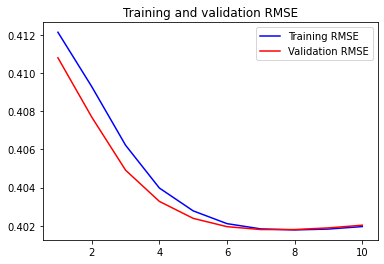

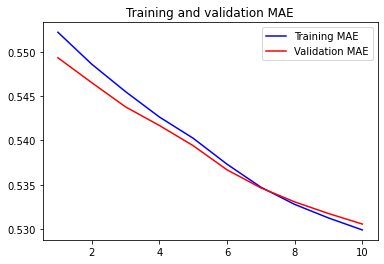

In [ ]:
plot_history(history)

In [ ]:
import pickle

def save_obj(obj,path):
    with open(path+'.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
path_epochs= 'EPOCHS %d '%(num_epochs)
path_MLP_layers='LAYERS %d' %(MLPLAYERS)
path_LR='LR %12.f'%(LR*100)
def save_model(path_MLP_layers,path_epochs,path_LR):
  path = '/content/drive/MyDrive/Evaluation Models/ConvHyb/Notre modèle /'
  version='W/O dense'
  ConvNHF.save(path+' '+'ConvNHF' +' '+ version+  ' ' +path_epochs+ ' ' +path_MLP_layers+' '+path_LR+'.h5', overwrite = True)
  np.save(path+' '+'ConvNHF' +' '+ version+  ' ' +path_epochs+ ' ' +path_MLP_layers+' '+path_LR+'.npy',history.history)
  save_obj(scores,path+' '+'ConvNHF' +' '+ version+  ' ' +path_epochs+ ' ' +path_MLP_layers+' '+path_LR)


In [ ]:
save_model(path_MLP_layers,path_epochs,path_LR)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
